In [10]:
## build researcher events, student events, and self-study events
## researcher are simply those with NH citations

In [11]:
import sys
sys.path.append('/home/users/wang2506/nanohub_salesforce_integ/salesforce')

import pandas as pd
import time
import datetime

from DB2SalesforceAPI import DB2SalesforceAPI

In [13]:
sf_login_params = {
    "grant_type": "password",
    "client_id": "3MVG95jctIhbyCppj0SNJ75IsZ1y8UPGZtSNF4j8FNVXz.De8Lu4jHm3rjRosAtsHy6qjHx3i4S_QbQzvBePG",
    "client_secret": "D1623C6D3607D4FC8004B92C761DFB6C1F70CCD129C5501E357028DFA00F5764",
    "username":"wang2506@purdue.edu",
    "password":"npass2021HDfJLhBGDx11xWCKlEbHQKhF",   
} 

## Nanohub user growth

In [5]:
## build jos_users_full
import sqlalchemy as sql
engine = sql.create_engine('mysql+pymysql://%s:%s@127.0.0.1/nanohub' \
                                               %('wang2506_ro', 'fnVnwcCS7iT45EsA'))

sql_query = "select id,name,username,email,registerDate,lastvisitDate from jos_users order by registerDate desc"
jos_users_full = pd.read_sql_query(sql_query, engine)
display(jos_users_full.head(2))
print(jos_users_full.shape)

OperationalError: (pymysql.err.OperationalError) (2003, "Can't connect to MySQL server on '127.0.0.1' ([Errno 111] Connection refused)")
(Background on this error at: http://sqlalche.me/e/14/e3q8)

2021-07-05 16:51:59,669 - [DEBUG] paramiko.transport [transport._log:1819]: Sending global request "keepalive@lag.net"
2021-07-05 16:52:00,171 - [DEBUG] paramiko.transport [transport._log:1819]: Sending global request "keepalive@lag.net"
2021-07-05 16:52:04,689 - [DEBUG] paramiko.transport [transport._log:1819]: Sending global request "keepalive@lag.net"
2021-07-05 16:52:05,190 - [DEBUG] paramiko.transport [transport._log:1819]: Sending global request "keepalive@lag.net"
2021-07-05 16:52:09,705 - [DEBUG] paramiko.transport [transport._log:1819]: Sending global request "keepalive@lag.net"
2021-07-05 16:52:10,206 - [DEBUG] paramiko.transport [transport._log:1819]: Sending global request "keepalive@lag.net"
2021-07-05 16:52:14,722 - [DEBUG] paramiko.transport [transport._log:1819]: Sending global request "keepalive@lag.net"
2021-07-05 16:52:15,224 - [DEBUG] paramiko.transport [transport._log:1819]: Sending global request "keepalive@lag.net"
2021-07-05 16:52:19,740 - [DEBUG] paramiko.trans

In [71]:
## build all users list
engine_metrics = sql.create_engine('mysql+pymysql://%s:%s@127.0.0.1/nanohub_metrics' \
                                               %('wang2506_ro', 'fnVnwcCS7iT45EsA'))
sql_query = "select datetime,ip,countryip,user,tool from toolstart where user != 'instanton' "\
+"and user != 'gridstat' and datetime <= '2002-01-01' and datetime >= '0000-01-01' order by datetime desc"
toolstart_df = pd.read_sql_query(sql_query, engine_metrics)
display(toolstart_df.head(2))
print(toolstart_df.shape)

,datetime,ip,countryip,user,tool
0,2001-12-31 23:23:51,68.32.42.69,US,jjeon,Adeptf
1,2001-12-31 23:23:23,68.32.42.69,US,jjeon,Adeptf


(138857, 5)


In [72]:
## convert the dataframes to datetime
jos_users_full['registerDate'] = pd.to_datetime(jos_users_full.registerDate)
jos_users_full['lastvisitDate'] = pd.to_datetime(jos_users_full.lastvisitDate)

toolstart_df['datetime'] = pd.to_datetime(toolstart_df.datetime)

In [46]:
all_months_list = list()
for this_year in range(2000,2021+1):
    for this_month in range(1,12+1):
        all_months_list.append(datetime.datetime(this_year, this_month, 1))
        
for this_year in range(2021,2022):
    for this_month in range(1,2):
        all_months_list.append(datetime.datetime(this_year, this_month, 1))
        
months_bin = pd.DataFrame(all_months_list, columns=['year_month'])

# display
months_bin.head(2)

,year_month
0,2000-01-01
1,2000-02-01


In [417]:
## jos_users_full registration cumulative monthly
months_bin['registered_12_trail'] = months_bin.year_month.apply(lambda x:  \
                                jos_users_full.username[(jos_users_full.registerDate < x)\
                            &(jos_users_full.registerDate > (x-datetime.timedelta(days=365)))].nunique() )

In [418]:
##the all users must be done in a bi-yearly basis
months_bin['sim_12_trail'] = months_bin.year_month.apply(lambda x: toolstart_df.user[(toolstart_df.datetime < x) \
                                        &(toolstart_df.datetime > (x-datetime.timedelta(days=365)))].nunique() )

In [51]:
import datetime

In [419]:
print(months_bin['year_month'].to_list().index(pd.to_datetime('2002-01-01')) )
temp = months_bin['sim_12_trail']#[:25]

24


In [420]:
print(temp[-5:])
print(temp[20:25])

260    11632
261    10123
262     7818
263     5374
264    21889
Name: sim_12_trail, dtype: int64
20    0
21    0
22    0
23    0
24    0
Name: sim_12_trail, dtype: int64


In [421]:
## computer has memory limits, so split the sim_12_trail into batches
start_year = 2002 #2002 #allows for flexibility as well for future updates

while start_year < 2021:#datetime.datetime.now().year:
    prev_temp_ind = months_bin['year_month'].to_list().index(pd.to_datetime(str(start_year)+'-01-01')) 
    
    start_year += 1
    end_date = r"'"+str(start_year)+r"-01-01'"
#     print(end_date)
    start_date = r"'"+str(start_year-2)+r"-01-01'"
    
    sql_query = "select datetime,ip,countryip,user,tool from toolstart where user != 'instanton' "\
        +"and user != 'gridstat' and datetime <= "+end_date+" and datetime >= "+start_date+" order by datetime desc"
    toolstart_df = pd.read_sql_query(sql_query, engine_metrics)
    toolstart_df['datetime'] = pd.to_datetime(toolstart_df.datetime)
    print(toolstart_df.shape)
    
    temp2 = months_bin.year_month.apply(lambda x: toolstart_df.user[(toolstart_df.datetime < x) \
                                        &(toolstart_df.datetime > (x-datetime.timedelta(days=365)))].nunique() )
    
    max_temp_ind = months_bin['year_month'].to_list().index(pd.to_datetime(str(start_year)+'-01-01')) 
    
    temp[prev_temp_ind:max_temp_ind] = temp2[prev_temp_ind:max_temp_ind]

(122148, 5)


C:\Users\ch5b2\anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(136210, 5)
(147533, 5)
(114575, 5)
(195951, 5)
(389282, 5)
(631227, 5)
(755597, 5)
(757271, 5)
(786048, 5)
(812523, 5)
(914351, 5)
(1326836, 5)
(1573469, 5)
(1594198, 5)
(2022509, 5)
(1932226, 5)
(1353033, 5)
(1642209, 5)


In [422]:
# calculating total number of visitors
import json
with open(cwd+'/visitors.json') as f:
    visitor_dict = f.read()
    visitor_dict = visitor_dict.replace("\'",'\"')
    visitor_dict = json.loads(visitor_dict)
#     visitor_dict.replace(r"'",r'"')
#     vicitor_dict = json.load(visitor_dict)

In [423]:
import re
pattern = re.compile('\d+]')
step1 = re.findall(pattern,visitor_dict['data'])
res_visitors = [i[:-1] for i in step1]

In [439]:
import numpy as np
res_visitors2 = list(np.zeros(12*6+14)) + res_visitors

In [440]:
print(len(res_visitors2))
print(res_visitors2[-5:])

263
['1940762', '1978362', '1967734', '2009618', '1872881']


In [441]:
display(months_bin.tail(10))

,year_month,registered_12_trail,sim_12_trail,visitors_12_trail
255,2021-04-01,26643,20136,1916142
256,2021-05-01,23465,17799,1950187
257,2021-06-01,20832,15503,1993458
258,2021-07-01,17963,13908,2010559
259,2021-08-01,16026,12786,1948323
260,2021-09-01,13651,11632,1940762
261,2021-10-01,11050,10123,1978362
262,2021-11-01,7910,7818,1967734
263,2021-12-01,4963,5374,2009618
264,2021-01-01,29969,21889,1872881


In [429]:
months_bin.shape

(265, 3)

In [431]:
months_bin['visitors_12_trail'] = res_visitors2
# months_bin['sim_12_trail'] = temp
display(months_bin.tail(10))

,year_month,registered_12_trail,sim_12_trail,visitors_12_trail
255,2021-04-01,26643,20136,1916142
256,2021-05-01,23465,17799,1950187
257,2021-06-01,20832,15503,1993458
258,2021-07-01,17963,13908,2010559
259,2021-08-01,16026,12786,1948323
260,2021-09-01,13651,11632,1940762
261,2021-10-01,11050,10123,1978362
262,2021-11-01,7910,7818,1967734
263,2021-12-01,4963,5374,2009618
264,2021-01-01,29969,21889,1872881


In [1135]:
display(months_bin.tail(15))

,year_month,registered_12_trail,sim_12_trail,visitors_12_trail
250,2020-11-01,27784,21071,1689647
251,2020-12-01,29029,21684,1643090
252,2021-01-01,29969,21889,1874508
253,2021-02-01,30502,22742,1898459
254,2021-03-01,29019,21640,1899399
255,2021-04-01,26643,20136,1916142
256,2021-05-01,23465,17799,1950187
257,2021-06-01,20832,15503,1993458
258,2021-07-01,17963,13908,2010559
259,2021-08-01,16026,12786,1948323


In [1132]:
months_bin.registered_12_trail[:-11]

0         15
1         19
2         24
3         26
4         30
       ...  
249    26655
250    27784
251    29029
252    29969
253    30502
Name: registered_12_trail, Length: 254, dtype: int64

In [1139]:
months_bin.sim_12_trail[:-11]

0          0
1          0
2          0
3          0
4          0
       ...  
249    20193
250    21071
251    21684
252    21889
253    22742
Name: sim_12_trail, Length: 254, dtype: int64

In [1130]:
#months_bin.to_csv('months_bin_backup.csv')

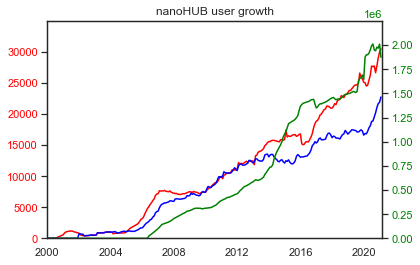

In [1155]:
from matplotlib import pyplot as plt
import seaborn as sns
import os
sns.set()
sns.set_style("white")
#plt.figure(figsize=(9,6))
fig, ax1 = plt.subplots()
ax1.clear()
ax1.plot(months_bin.year_month[:-11], months_bin.registered_12_trail[:-11], color='red', label='New Registered Users');
ax1.plot(months_bin.year_month[:-11], months_bin.sim_12_trail[:-11], color='blue', label='Simulation Users');
#plt.plot(months_bin.year_month,res_visitors2)

ax1.set_title('nanoHUB user growth');

ax1.set_xlim([datetime.datetime(2000,1,1), datetime.datetime(2021,3,1)]);
ax1.set_ylim([0, 35000])
ax1.set_yticks(np.arange(0,35000,5000))
ax1.tick_params(axis='y',labelcolor='red')
# ax1.set_ylabel('Unique Users/Month')

ax2 = ax1.twinx()
# ax2.set_ylabel('Unique Visitors/Month')
ax2.plot(months_bin.year_month[:-11],months_bin.visitors_12_trail[11:],color='green',label='Unique Monthly Visitors')
ax2.tick_params(axis='y',labelcolor='green')
ax2.set_yticks(np.arange(0,2000000+250000,250000))
ax2.set_ylim([0,2000000+250000])
# ax2.legend(loc='center left')
# plt.ylabel('Annualized nanoHUB Visitors');
# ax1.legend(loc='upper left');
cwd = os.getcwd()
ax1.legend(True)
plt.savefig(cwd+'/appendixF_plots/overall_user_growth_legend.eps', dpi=500, bbox_inches='tight')
# plt.savefig(cwd+'/appendixF_plots/overall_user_growth_no_legend.png', dpi=500, bbox_inches='tight')
# users_registrered_visitors_12_months - new name

In [468]:
print(months_bin.registered_12_trail[-13:-12])
print(months_bin.sim_12_trail[-13:-12])
print(months_bin.visitors_12_trail[-2:-1])

252    29969
Name: registered_12_trail, dtype: int64
252    21889
Name: sim_12_trail, dtype: int64
263    2009618
Name: visitors_12_trail, dtype: object


In [460]:
months_bin.year_month[:-12]

0     2000-01-01
1     2000-02-01
2     2000-03-01
3     2000-04-01
4     2000-05-01
         ...    
248   2020-09-01
249   2020-10-01
250   2020-11-01
251   2020-12-01
252   2021-01-01
Name: year_month, Length: 253, dtype: datetime64[ns]

## Cumulative classroom/research/self-study

In [8]:
###
# 1. pull all unique classroom users from SF
# 2. pull all research users from DB2
# 3. pull all contacts from SF
# 4. iteratively pull toolstart df again by year starting from 2000

In [9]:
## pull all classroom users from SF
db_1 = DB2SalesforceAPI(sf_login_params)

Obtained Salesforce access token ...... True


In [10]:
## pull the list of contacts within each cluster
contacts_in_cluster_df = db_1.query_data('Select Contact__c, Tool_Usage_Cluster__c from ContactToolClusterAssociation__c')

[Success] Bulk job creation successful. Job ID = 7505w00000WwbkPAAR
{"id":"7505w00000WwbkPAAR","operation":"query","object":"ContactToolClusterAssociation__c","createdById":"0055w00000DM5bOAAT","createdDate":"2021-06-14T03:38:31.000+0000","systemModstamp":"2021-06-14T03:38:31.000+0000","state":"UploadComplete","concurrencyMode":"Parallel","contentType":"CSV","apiVersion":47.0,"jobType":"V2Query","lineEnding":"LF","columnDelimiter":"COMMA","retries":0,"totalProcessingTime":0}
{"id":"7505w00000WwbkPAAR","operation":"query","object":"ContactToolClusterAssociation__c","createdById":"0055w00000DM5bOAAT","createdDate":"2021-06-14T03:38:31.000+0000","systemModstamp":"2021-06-14T03:38:40.000+0000","state":"JobComplete","concurrencyMode":"Parallel","contentType":"CSV","apiVersion":47.0,"jobType":"V2Query","lineEnding":"LF","columnDelimiter":"COMMA","numberRecordsProcessed":98079,"retries":0,"totalProcessingTime":6925}
[Success] Bulk job completed successfully.


In [11]:
display(contacts_in_cluster_df.head(2))
print(contacts_in_cluster_df.shape)

,Contact__c,Tool_Usage_Cluster__c
0,0035w000034JG1EAAW,a0w5w000009Q7m3AAC
1,0035w000034I5sjAAC,a0w5w000009Q7m3AAC


(98079, 2)


In [12]:
## if SF processing errors
if contacts_in_cluster_df.shape[0] <= 100:
    contacts_in_cluster_df = pd.read_csv(cwd+'/backup_contacts_in_clusters.csv')
    contacts_in_cluster_df = contacts_in_cluster_df.drop(columns=['Unnamed: 0'])
display(contacts_in_cluster_df.head(2))
print(contacts_in_cluster_df.shape)

,Contact__c,Tool_Usage_Cluster__c
0,0035w000034JG1EAAW,a0w5w000009Q7m3AAC
1,0035w000034I5sjAAC,a0w5w000009Q7m3AAC


(98079, 2)


In [13]:
unique_contacts_in_clusters = set(contacts_in_cluster_df['Contact__c'].to_list())
print(len(unique_contacts_in_clusters))

63484


In [14]:
contacts_df = db_1.query_data('Select Id, nanoHUB_user_ID__c from Contact')

[Success] Bulk job creation successful. Job ID = 7505w00000WwbkUAAR
{"id":"7505w00000WwbkUAAR","operation":"query","object":"Contact","createdById":"0055w00000DM5bOAAT","createdDate":"2021-06-14T03:38:45.000+0000","systemModstamp":"2021-06-14T03:38:45.000+0000","state":"UploadComplete","concurrencyMode":"Parallel","contentType":"CSV","apiVersion":47.0,"jobType":"V2Query","lineEnding":"LF","columnDelimiter":"COMMA","retries":0,"totalProcessingTime":0}
{"id":"7505w00000WwbkUAAR","operation":"query","object":"Contact","createdById":"0055w00000DM5bOAAT","createdDate":"2021-06-14T03:38:45.000+0000","systemModstamp":"2021-06-14T03:38:45.000+0000","state":"InProgress","concurrencyMode":"Parallel","contentType":"CSV","apiVersion":47.0,"jobType":"V2Query","lineEnding":"LF","columnDelimiter":"COMMA","numberRecordsProcessed":0,"retries":0,"totalProcessingTime":0}
{"id":"7505w00000WwbkUAAR","operation":"query","object":"Contact","createdById":"0055w00000DM5bOAAT","createdDate":"2021-06-14T03:38:45

In [15]:
display(contacts_df.head(2))
print(contacts_df.shape)

,Id,nanoHUB_user_ID__c
0,0035w000031Vsp1AAC,998.0
1,0035w000031Vsp2AAC,1683.0


(249065, 2)


In [16]:
## determine self-study users, i.e., unclassified users
# if sf id is in contacts_in_cluster_df['Contact__c'], then it is self-study

self_study = []
clustered = []

sf_contact_ids = contacts_df['Id'].to_list()

import numpy as np
# bool_search = np.in1d(np.array(list(unique_contacts_in_clusters)),np.array(sf_contact_ids))
bool_search = np.in1d(np.array(sf_contact_ids),np.array(list(unique_contacts_in_clusters)))

clustered = np.where(bool_search)[0].tolist()
self_study = np.where(~bool_search)[0].tolist()

In [17]:
clustered_NH_ids = contacts_df['nanoHUB_user_ID__c'][clustered]
self_study_NH_ids = contacts_df['nanoHUB_user_ID__c'][self_study]

In [18]:
print(clustered_NH_ids.shape)
print(self_study_NH_ids.shape)

(63484,)
(185581,)


In [19]:
## need to filter self-study-nh-ids with the researchers

In [23]:
## pull in research users
import sqlalchemy as sql
sql_query = "select uidNumber from jos_citations_authors where uidNumber != 0"
engine = sql.create_engine('mysql+pymysql://%s:%s@127.0.0.1/nanohub' \
                                               %('wang2506_ro', 'fnVnwcCS7iT45EsA'))
researcher_ids = pd.read_sql_query(sql_query, engine)
display(researcher_ids.head(2))

,uidNumber
0,1742
1,1742


In [24]:
researcher_ids2 = researcher_ids.drop_duplicates()['uidNumber']
researcher_ids2 = researcher_ids2.to_list()

In [25]:
researcher_ids.shape

(9765, 1)

In [26]:
len(researcher_ids2)

1894

In [27]:
sf_contact_ids = contacts_df['nanoHUB_user_ID__c'][self_study]

In [28]:
sf_contact_ids = sf_contact_ids.reset_index()
sf_contact_ids = sf_contact_ids.drop(columns='index')
display(sf_contact_ids)

,nanoHUB_user_ID__c
0,998.0
1,1683.0
2,1684.0
3,1685.0
4,1686.0
...,...
185576,329897.0
185577,329909.0
185578,329862.0
185579,329917.0


In [29]:
bool_search2 = np.in1d(np.array(sf_contact_ids['nanoHUB_user_ID__c'].to_list()),np.array(researcher_ids2))

In [30]:
researchers = np.where(bool_search2)[0].tolist()
self_study2 = np.where(~bool_search2)[0].tolist()

In [31]:
print(len(researchers))
print(len(self_study2))

1309
184272


In [32]:
clustered_NH_ids = pd.DataFrame(contacts_df['nanoHUB_user_ID__c'][clustered]) # already done
self_study_NH_ids = pd.DataFrame(pd.DataFrame(sf_contact_ids).iloc[self_study2,:])
researcher_NH_ids = pd.DataFrame(pd.DataFrame(sf_contact_ids).iloc[researchers,:])

In [33]:
researcher_NH_ids

,nanoHUB_user_ID__c
21,43786.0
59,43831.0
150,43927.0
238,54290.0
258,54333.0
...,...
145793,169847.0
146561,159469.0
147398,175461.0
148560,228768.0


In [34]:
## loading in toolstart

In [35]:
# matching ids to usernames
sql_query2 = "select id,username from jos_users"
id_username_df = pd.read_sql_query(sql_query2, engine)
display(id_username_df.head(2))

,id,username
0,211547,-100005
1,211574,-100024


In [36]:
usernames_db2 = id_username_df['id'].to_list()

In [37]:
t_cluster = np.in1d(usernames_db2,clustered_NH_ids['nanoHUB_user_ID__c'])
clustered_NH_username = np.where(t_cluster)[0].tolist()
clustered_NH_username2 = pd.DataFrame(id_username_df['username'][clustered_NH_username])
display(clustered_NH_username2)

,username
12637,0.yao.yuan
12642,008dilip
12646,01024461660a
12652,01luiyi
12654,0214moon
...,...
251242,zztman117
251243,zztt93
251245,zzumich
251259,zzz777


In [38]:
t_research = np.in1d(usernames_db2,researcher_NH_ids['nanoHUB_user_ID__c'])
researcher_NH_username = np.where(t_research)[0].tolist()
researcher_NH_username2 = pd.DataFrame(id_username_df['username'][researcher_NH_username])
display(researcher_NH_username2)

,username
968,-113426
2463,-13370
6806,-18285
6949,-20433
7617,-3549
...,...
250544,zoso0789
250560,zouave
250655,zrbyte
250798,zubair0995


In [39]:
t_self_study = np.in1d(usernames_db2,self_study_NH_ids['nanoHUB_user_ID__c'])
self_NH_username = np.where(t_self_study)[0].tolist()
self_NH_username2 = pd.DataFrame(id_username_df['username'][self_NH_username])
display(self_NH_username2)

,username
0,-100005
1,-100024
2,-100026
3,-100032
4,-10006
...,...
251266,z_depth
251267,z_e_u_s
251269,z_kamal
251270,z_sath


In [40]:
# clustered_NH_username2;researcher_NH_username2;self_NH_username2
clustered_track = []
self_track = []
researcher_track = []

clustered_track_per = []
self_track_per = []
researcher_track_per = []

In [42]:
engine_metrics = sql.create_engine('mysql+pymysql://%s:%s@127.0.0.1/nanohub_metrics' \
                                               %('wang2506_ro', 'fnVnwcCS7iT45EsA'))

In [43]:
## computer has memory limits, so split toolstart into branches
start_year = 2000 #2002 #allows for flexibility as well for future updates

while start_year < 2021:#datetime.datetime.now().year:
    start_year += 1
    end_date = r"'"+str(start_year)+r"-01-01'"
#     print(end_date)
    start_date = r"'"+str(start_year-2)+r"-01-01'"
    
    for i in range(1,13):
        if i < 10:
            start_date = r"'"+str(start_year-1)+r"-0"+str(i)+r"-01'"
            end_date = r"'"+str(start_year)+r"-0"+str(i)+r"-01'"
        else:
            start_date = r"'"+str(start_year-1)+r"-"+str(i)+r"-01'"
            end_date = r"'"+str(start_year)+r"-"+str(i)+r"-01'"
        ## unique active users
#         current = time.time()
#         sql_query_clustered = "select count(distinct user) from toolstart where user in " + str(tuple(clustered_NH_username2['username']))\
#             +" and datetime <= "+end_date+" and datetime >= "+start_date
#         clustered_users = pd.read_sql_query(sql_query_clustered, engine_metrics)
        
#         sql_query_self = "select count(distinct user) from toolstart where user in " + str(tuple(self_NH_username2['username']))\
#             +" and datetime <= "+end_date+" and datetime >= "+start_date
#         self_users = pd.read_sql_query(sql_query_self, engine_metrics)
        
#         sql_query_researcher = "select count(distinct user) from toolstart where user in " + str(tuple(researcher_NH_username2['username']))\
#             +" and datetime <= "+end_date+" and datetime >= "+start_date
#         researcher_users = pd.read_sql_query(sql_query_researcher, engine_metrics)
        
        sql_query_clustered = "select user from toolstart where user in " + str(tuple(clustered_NH_username2['username']))\
            +" and datetime <= "+end_date+" and datetime >= "+start_date
        clustered_users = pd.read_sql_query(sql_query_clustered, engine_metrics)#.drop_duplicates()
        
        sql_query_self = "select user from toolstart where user in " + str(tuple(self_NH_username2['username']))\
            +" and user != 'instanton' and user != 'gridstat' and datetime <= "+end_date+" and datetime >= "+start_date
        self_users = pd.read_sql_query(sql_query_self, engine_metrics)#.drop_duplicates()
        
        sql_query_researcher = "select user from toolstart where user in " + str(tuple(researcher_NH_username2['username']))\
            +" and datetime <= "+end_date+" and datetime >= "+start_date
        researcher_users = pd.read_sql_query(sql_query_researcher, engine_metrics)#.drop_duplicates()

#         sql_query_all =  "select user from toolstart where user not in ('gridstat','instanton')" \
#             +" and datetime <= "+end_date+" and datetime >= "+start_date
#         all_users = pd.read_sql_query(sql_query_all, engine_metrics)#.drop_duplicates()
#         print(time.time() - current)
#         clustered_track.append(clustered_users['count(distinct user)'][0])
#         self_track.append(self_users['count(distinct user)'][0])
#         researcher_track.append(researcher_users['count(distinct user)'][0])

        clustered_track.append(clustered_users.drop_duplicates().shape[0])
        self_track.append(self_users.drop_duplicates().shape[0])
        researcher_track.append(researcher_users.drop_duplicates().shape[0])

#         clustered_track_per.append(clustered_users.shape[0]/all_users.shape[0])
#         self_track_per.append(self_users.shape[0]/all_users.shape[0])
#         researcher_track_per.append(researcher_users.shape[0]/all_users.shape[0])        
        
#         print(clustered_users)
#         print(self_users)
#         print(researcher_users)
    print(start_year)

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


In [47]:
months_bin.year_month

0     2000-01-01
1     2000-02-01
2     2000-03-01
3     2000-04-01
4     2000-05-01
         ...    
260   2021-09-01
261   2021-10-01
262   2021-11-01
263   2021-12-01
264   2021-01-01
Name: year_month, Length: 265, dtype: datetime64[ns]

In [48]:
user_breakdown_df = pd.DataFrame()
user_breakdown_df['year_month'] = months_bin['year_month'].to_list()[13:]
user_breakdown_df['clustered_track'] = clustered_track
user_breakdown_df['self_track'] = self_track
user_breakdown_df['researcher_track'] = researcher_track
user_breakdown_df.head(2)

,year_month,clustered_track,self_track,researcher_track
0,2001-02-01,161,237,9
1,2001-03-01,323,280,11


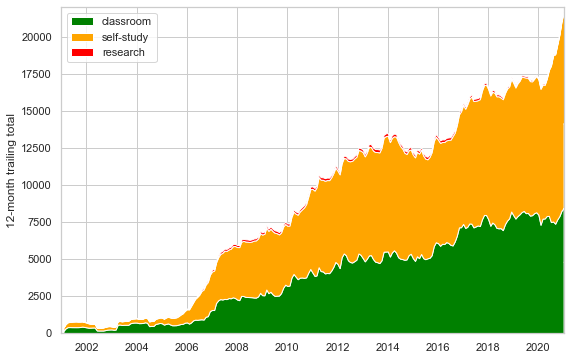

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set()
sns.set_style("whitegrid")

plt.figure(figsize=(9,6))
plt.stackplot(user_breakdown_df.year_month, \
              user_breakdown_df[['clustered_track', 'self_track', 'researcher_track']].to_numpy().T, \
             labels=['classroom', 'self-study', 'research'], \
             colors=['green', 'orange', 'red']);

plt.legend(loc='upper left');
plt.ylabel('12-month trailing total')
plt.xlim([datetime.datetime(2001,1,1), datetime.datetime(2021,1,1)])
plt.ylim([0, 22000])

# plt.savefig('./sim_user_by_type_1.svg', bbox_inches='tight')

plt.show()

In [52]:
user_breakdown_df.tail(15)

,year_month,clustered_track,self_track,researcher_track
237,2020-11-01,7905,12228,71
238,2020-12-01,8259,12756,69
239,2021-01-01,8452,13208,64
240,2021-02-01,8359,13465,60
241,2021-03-01,8635,14043,63
242,2021-04-01,8915,14498,60
243,2021-05-01,8966,14734,60
244,2021-06-01,8523,14797,59
245,2021-07-01,7838,15168,58
246,2021-08-01,7482,14372,60


In [53]:
## check researchers
engine = sql.create_engine('mysql+pymysql://%s:%s@127.0.0.1/nanohub' \
                                               %('wang2506_ro', 'fnVnwcCS7iT45EsA'))

sql_query = "select uidNumber,givenName,surname from jos_citations_authors"
jos_citations_authors = pd.read_sql_query(sql_query, engine)


In [54]:
jos_citations_authors

,uidNumber,givenName,surname
0,100100,Woody,Gilbertson
1,42735,Hesameddin,Ilatikhameneh
2,52349,Daniel,Mejia
3,65635,James,Charles
4,72949,Prasad,Sarangapani
...,...,...,...
16661,0,NB,Balamurugan
16662,0,M.,Kurz
16663,0,S,Chandra
16664,0,WR,Frensley


In [55]:
sql_query = 'select id, uid, author from jos_citations'
jos_citations = pd.read_sql_query(sql_query, engine)

In [56]:
jos_citations

,id,uid,author
0,10000001,5568,"Weber, Bent; Mahapatra, Suddhasatta; Ryu, Hoon..."
1,10000002,5568,"Andrawis, Robert; Bermeo, Jose; Charles, James..."
2,10000003,None,Sebastian Steiger;Michael Povolotskyi;Hong-Hyu...
3,10000004,None,Muhammad Usman;Yui-Hong Matthias Tan;Hoon Ryu;...
4,10000005,None,Neophytos Neophytou;Gerhard Klimeck;Hans Kosina
...,...,...,...
4150,1535,2143,Amir Abedi
4151,627,2143,Jesper Pedersen;Lei Zhang{{38142}};M. Gilbert;...
4152,423,2143,WR Frensley
4153,2118,2143,T. Rupasinghe;M. Kurz


In [57]:
t1_authors = jos_citations['author'].to_list()

In [58]:
t1_authors2 = [] #[j.split(';') for i,j in enumerate(t1_authors)]

In [59]:
for i,j in enumerate(t1_authors):
    try:
        holder = j.split(';')
        if len(holder) > 1: 
            for k,l in enumerate(holder):
                if l[0] == ' ':
                    holder[k] = l[1:]
        t1_authors2.append(holder)
    except:
        garb = True

In [60]:
t1_authors3 = [item for sublist in t1_authors2 for item in sublist]

In [61]:
t1_authors3 = set(t1_authors3)

In [62]:
len(t1_authors3)

6709

In [63]:
## extract all researchers with nh ids
rw_ids = []
need_search = []
for i,j in enumerate(t1_authors3):
    if '{{' in j:
        rw_ids.append(i)
    else:
        need_search.append(i)

In [64]:
## from the rw_ids, extract the nanohub userids
# can obtain usernames from the DB2 table
rw_ids2 = np.array(list(t1_authors3))[rw_ids]
for i,j in enumerate(rw_ids2):
    begin = j.index('{{')
    rw_ids2[i] = j[begin+2:-2]

In [65]:
print(len(rw_ids2))

2076


In [66]:
# need to obtain usernames
sql_query = "select id,name,username from jos_users where id in "+str(tuple(rw_ids2))
rw_researchers = pd.read_sql_query(sql_query,engine)
display(rw_researchers.head(2))

,id,name,username
0,1742,H.-S. Philip Wong,hspwong
1,1767,Osama Munir Nayfeh,onayfeh


In [67]:
## need to obtain the username/ids from those people without nh ids explicitly spec'd in jos_citations
ns2 = np.array(list(t1_authors3))[need_search]
ns2 = ns2[1:]

In [68]:
tuple(ns2)[:5]

('T. Nakamura',
 'Xingwu Liu',
 'Monique Groenewold',
 'R. Govindaraju',
 'Yuling Hsueh')

In [69]:
sql_query = "select id,name,username from jos_users where name in "+str(tuple(ns2))
ns2_researchers = pd.read_sql_query(sql_query,engine)
display(ns2_researchers.head(2))

,id,name,username
0,282167,Aarthi Narayanan,aarthin0102
1,280280,Abani Patra,apatra01


In [70]:
## combine the usernames into one data structure
researcher_usernames = rw_researchers['username'].to_list() + ns2_researchers['username'].to_list()

In [71]:
len(researcher_usernames)

2875

In [72]:
researcher_track = []
engine_metrics = sql.create_engine('mysql+pymysql://%s:%s@127.0.0.1/nanohub_metrics' \
                                               %('wang2506_ro', 'fnVnwcCS7iT45EsA'))

In [73]:
## computer has memory limits, so split toolstart into branches
start_year = 2000 #2002 #allows for flexibility as well for future updates

while start_year < 2021:#datetime.datetime.now().year:
    start_year += 1
    end_date = r"'"+str(start_year)+r"-01-01'"
#     print(end_date)
    start_date = r"'"+str(start_year-2)+r"-01-01'"
    
    for i in range(1,13):
        if i < 10:
            start_date = r"'"+str(start_year-1)+r"-0"+str(i)+r"-01'"
            end_date = r"'"+str(start_year)+r"-0"+str(i)+r"-01'"
        else:
            start_date = r"'"+str(start_year-1)+r"-"+str(i)+r"-01'"
            end_date = r"'"+str(start_year)+r"-"+str(i)+r"-01'"

        sql_query_researcher = "select user from toolstart where user in " + str(tuple(researcher_usernames))\
            +" and datetime <= "+end_date+" and datetime >= "+start_date
        researcher_users = pd.read_sql_query(sql_query_researcher, engine_metrics)#.drop_duplicates()

        researcher_track.append(researcher_users.drop_duplicates().shape[0])

    print(start_year)

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


In [76]:
user_breakdown_df['researcher_track'] = researcher_track

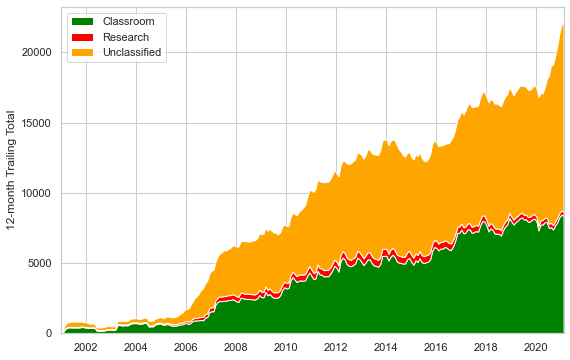

In [134]:
sns.set()
sns.set_style("whitegrid")

plt.figure(figsize=(9,6))
# plt.figure(figsize=(6,6))
user_breakdown_df2 = user_breakdown_df.iloc[:-11,:]
plt.stackplot(user_breakdown_df2.year_month, \
              user_breakdown_df2[['clustered_track', 'researcher_track','self_track']].to_numpy().T, \
             labels=['Classroom','Research', 'Unclassified'], \
             colors=['green', 'red', 'orange']); #Self-study

plt.legend(loc='upper left')#,fontsize=14);
plt.ylabel('12-month Trailing Total')#,fontsize=15)

plt.xlim([datetime.datetime(2001,1,1), datetime.datetime(2021,2,1)])#,fontsize=15)

# test = plt.xticks()
# # print(test)
# # print([i.get_text() for i in test[1]])
# plt.xticks(ticks=test[0][1:-1],labels=[str(i) for i in range(2002,2021,2)],fontsize=14)
# # plt.xticks(ticks=['2001:1:1','2021:1:1'])#list(range(2000,2021,2)))#, \
# #     labels=list(range(2000,2021,2)),fontsize=12)

# test_y = plt.yticks()
# plt.yticks(ticks=test_y[0][0:-1],labels=[str(i) for i in range(0,21000,5000)],fontsize=14)

# plt.xlim_labels('')
# plt.ylim([0, 24000],fontsize=15)

# plt.savefig(cwd+'/appendixF_plots/sim_user_by_type.png', dpi=500,bbox_inches='tight')
# plt.savefig(cwd+'/appendixF_plots/sim_user_by_type.eps',bbox_inches='tight')
# import os
# cwd = os.getcwd()
# plt.savefig(cwd+'/appendixF_plots/sim_user_by_type_HICSS.png', dpi=1500,bbox_inches='tight')

plt.show()
# new name - simusers_class_res_unclass_12months

In [1148]:
user_breakdown_df2['clustered_track'].to_list()[-5:]

[7717, 7913, 8259, 8430, 8281]

In [1153]:
user_breakdown_df2['clustered_track_per'] = 100*np.divide(user_breakdown_df2['clustered_track'],\
            user_breakdown_df2['clustered_track'].to_numpy()+user_breakdown_df2['researcher_track'].to_numpy()+\
                        user_breakdown_df2['self_track'].to_numpy())
user_breakdown_df2['researcher_track_per'] = 100*np.divide(user_breakdown_df2['researcher_track'],\
            user_breakdown_df2['clustered_track'].to_numpy()+user_breakdown_df2['researcher_track'].to_numpy()+\
                        user_breakdown_df2['self_track'].to_numpy())
user_breakdown_df2['self_track_per'] = 100*np.divide(user_breakdown_df2['self_track'],\
            user_breakdown_df2['clustered_track'].to_numpy()+user_breakdown_df2['researcher_track'].to_numpy()+\
                        user_breakdown_df2['self_track'].to_numpy())

C:\Users\ch5b2\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\ch5b2\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\ch5b2\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


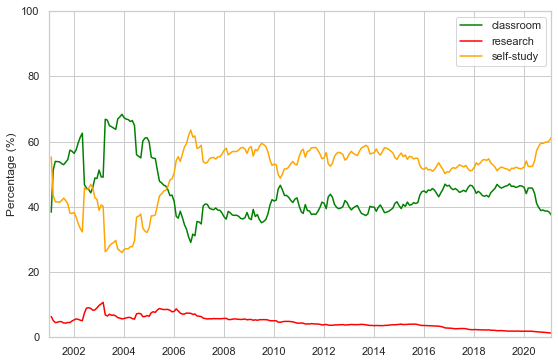

In [1154]:
plt.figure(figsize=(9,6))
plt.plot(user_breakdown_df2.year_month, user_breakdown_df2.clustered_track_per, label='classroom', \
             color='green');
plt.plot(user_breakdown_df2.year_month, user_breakdown_df2.researcher_track_per, label='research', \
             color='red');
plt.plot(user_breakdown_df2.year_month, user_breakdown_df2.self_track_per, label='self-study', \
             color='orange');

plt.ylim([0, 100])
plt.legend(loc='upper right');
plt.ylabel('Percentage (%)');
plt.xlim([datetime.datetime(2001,1,1), datetime.datetime(2021,2,1)])

# plt.savefig(cwd+'/appendixF_plots/sim_user_by_type_per.png', dpi=500,bbox_inches='tight')
plt.savefig(cwd+'/appendixF_plots/sim_user_by_type_per.eps',bbox_inches='tight')

plt.show()
# new name - take name from above add a "_percent"

## Figure: active simulation users by geolocation

In [756]:
## need to do iterative importing once again

In [757]:
engine_metrics = sql.create_engine('mysql+pymysql://%s:%s@127.0.0.1/nanohub_metrics' \
                                               %('wang2506_ro', 'fnVnwcCS7iT45EsA'))

In [795]:
country_df = pd.DataFrame()
country_df['year_month'] = months_bin['year_month'].to_list()[13:-11]

In [796]:
country_df

,year_month
0,2001-02-01
1,2001-03-01
2,2001-04-01
3,2001-05-01
4,2001-06-01
...,...
236,2020-10-01
237,2020-11-01
238,2020-12-01
239,2021-01-01


In [784]:
usa = []
china = []
eu = []
india = []
other = []
eu_list = ['BE','BG','EL','CZ','DK','DE','EE','IE','ES','FR','HR','IT','CY','LV',\
          'LT','LU','HU','MT','NL','AT','PL','PT','RO','SI','SK','FI','SE','IS',\
           'NO','LI','CH','UK','ME','MK','AL','RS','TR','BA','XK','AM','AZ','BY',\
           'MD','GE','UA','RU']

In [787]:
## computer has memory limits, so split toolstart into branches
start_year = 2000 #2002 #allows for flexibility as well for future updates

while start_year < 2021:#datetime.datetime.now().year:
    start_year += 1
#     end_date = r"'"+str(start_year)+r"-01-01'"
# #     print(end_date)
#     start_date = r"'"+str(start_year-1)+r"-01-01'"
    
    for i in range(1,13):
        if i < 10:
            start_date = r"'"+str(start_year-1)+r"-0"+str(i)+r"-01'"
            end_date = r"'"+str(start_year)+r"-0"+str(i)+r"-01'"
        else:
            start_date = r"'"+str(start_year-1)+r"-"+str(i)+r"-01'"
            end_date = r"'"+str(start_year)+r"-"+str(i)+r"-01'"

        sql_query_country = "select distinct user, countryip from toolstart where user != 'instanton' "\
        + "and user != 'gridstat' and datetime <= "+end_date+" and datetime >= "+start_date
        country_users = pd.read_sql_query(sql_query_country, engine_metrics)#.drop_duplicates()
        
        # run geography filter
        country_ipds = country_users['countryip'].to_list()
        
        bool_US = np.in1d(np.array(country_ipds),np.array(['US']))
        bool_EU = np.in1d(np.array(country_ipds),np.array(eu_list))
        bool_CN = np.in1d(np.array(country_ipds),np.array(['CN']))
        bool_IN = np.in1d(np.array(country_ipds),np.array(['IN']))
#         bool_OT = bool_US | bool_EU | bool_CN | bool_IN
        
        usa.append(len(np.where(bool_US)[0].tolist()))
        eu.append(len(np.where(bool_EU)[0].tolist()))
        china.append(len(np.where(bool_CN)[0].tolist()))
        india.append(len(np.where(bool_IN)[0].tolist()))
        other.append(len(country_ipds)-usa[-1]-eu[-1]-china[-1]-india[-1]) # len(np.where(bool_OT)[0].tolist()))
        
#         country_users.append(country_users.drop_duplicates().shape[0])

    print(start_year)

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


In [798]:
country_df.shape

(241, 1)

In [816]:
usa[-8:]

[8245, 6881, 6044, 5487, 5122, 4684, 4073, 3005, 2018]

In [821]:
print(len(usa))
usa2 = usa[37:-8]
print(len(usa2))

286
241


In [825]:
country_df['USA'] = usa[37:-8]
country_df['China'] = china[37:-8]
country_df['Europe'] = eu[37:-8]
country_df['India'] = india[37:-8]
country_df['Other'] = other[37:-8]

In [826]:
country_df

,year_month,USA,China,Europe,India,Other,Total
0,2001-02-01,849,5,58,2,32,946
1,2001-03-01,775,5,58,2,38,878
2,2001-04-01,760,5,55,2,40,862
3,2001-05-01,755,7,56,2,42,862
4,2001-06-01,744,7,54,2,43,850
...,...,...,...,...,...,...,...
236,2020-10-01,9008,432,4006,3531,6068,23045
237,2020-11-01,8881,436,4107,3621,6224,23269
238,2020-12-01,9256,441,4185,3670,6643,24195
239,2021-01-01,8800,425,4055,3479,6423,23182


In [827]:
country_df['Total'] = np.array(usa[37:-8])+np.array(china[37:-8])+np.array(eu[37:-8])+np.array(india[37:-8])+np.array(other[37:-8])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


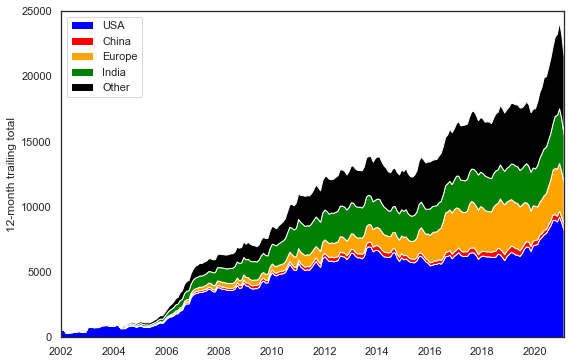

In [1156]:
plt.figure(figsize=(9,6))
plt.stackplot(country_df['year_month'], \
              country_df[['USA', 'China', 'India', 'Europe', 'Other']].to_numpy().T, \
             labels=country_df.columns.to_list()[1:-1], \
             colors=['blue', 'red', 'orange', 'green', 'black']);

plt.legend(loc='upper left');
plt.ylabel('12-month trailing total')
plt.xlim([datetime.datetime(2002,1,1), datetime.datetime(2021,2,1)]);
plt.ylim([0, 25000])

# plt.savefig(cwd+'/appendixF_plots/sim_user_by_country.png', dpi=500,bbox_inches='tight')
plt.savefig(cwd+'/appendixF_plots/sim_user_by_country.eps',bbox_inches='tight')

plt.show()
# new name - simusers_geo_12months

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


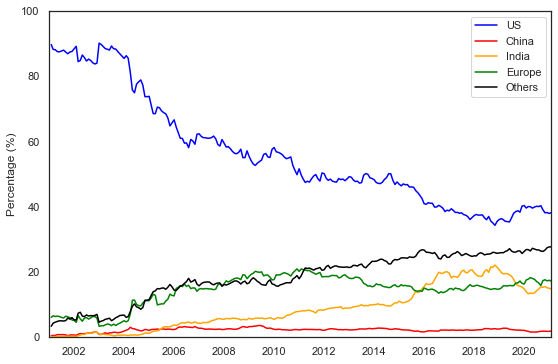

In [1157]:
plt.figure(figsize=(9,6))
plt.plot(country_df['year_month'], \
         country_df['USA'].to_numpy()/country_df['Total'].to_numpy() *100\
         , label='US', color='blue');
plt.plot(country_df['year_month'], \
         country_df['China'].to_numpy()/country_df['Total'].to_numpy() *100\
         , label='China', color='red');
plt.plot(country_df['year_month'], \
         country_df['India'].to_numpy()/country_df['Total'].to_numpy() *100\
         , label='India', color='orange');
plt.plot(country_df['year_month'], \
         country_df['Europe'].to_numpy()/country_df['Total'].to_numpy() *100\
         , label='Europe', color='green');
plt.plot(country_df['year_month'], \
         country_df['Other'].to_numpy()/country_df['Total'].to_numpy() *100\
         , label='Others', color='black');

plt.xlim([datetime.datetime(2001,1,1), datetime.datetime(2021,2,1)])
plt.ylim([0, 100])
plt.legend(loc='upper right');
plt.ylabel('Percentage (%)')

# plt.savefig(cwd+'/appendixF_plots/sim_user_by_country_perc.png', dpi=500,bbox_inches='tight')
plt.savefig(cwd+'/appendixF_plots/sim_user_by_country_perc.eps',bbox_inches='tight')

plt.show()
# add '_percent'

## Classroom activity plots

In [837]:
## students and classes per semester

In [899]:
## pull all classroom users from SF
db_1 = DB2SalesforceAPI(sf_login_params)

Obtained Salesforce access token ...... True


In [903]:
## pull the list of contacts within each cluster
contacts_in_cluster_df = db_1.query_data('Select Id, Contact__c, Tool_Usage_Cluster__c from ContactToolClusterAssociation__c')

[Success] Bulk job creation successful. Job ID = 7505w00000Tp79KAAR
{"id":"7505w00000Tp79KAAR","operation":"query","object":"ContactToolClusterAssociation__c","createdById":"0055w00000DM5bOAAT","createdDate":"2021-02-04T21:03:45.000+0000","systemModstamp":"2021-02-04T21:03:45.000+0000","state":"UploadComplete","concurrencyMode":"Parallel","contentType":"CSV","apiVersion":47.0,"jobType":"V2Query","lineEnding":"LF","columnDelimiter":"COMMA","retries":0,"totalProcessingTime":0}
{"id":"7505w00000Tp79KAAR","operation":"query","object":"ContactToolClusterAssociation__c","createdById":"0055w00000DM5bOAAT","createdDate":"2021-02-04T21:03:45.000+0000","systemModstamp":"2021-02-04T21:03:47.000+0000","state":"InProgress","concurrencyMode":"Parallel","contentType":"CSV","apiVersion":47.0,"jobType":"V2Query","lineEnding":"LF","columnDelimiter":"COMMA","numberRecordsProcessed":89607,"retries":0,"totalProcessingTime":14025}
{"id":"7505w00000Tp79KAAR","operation":"query","object":"ContactToolClusterAs

In [904]:
contacts_in_cluster_df

,Contact__c,Id,Tool_Usage_Cluster__c
0,0035w000031Vv3bAAC,a0x5w00000c2TB2AAM,a0w5w000009Q8ZRAA0
1,0035w000034JHc2AAG,a0x5w00000c2TCHAA2,a0w5w00000A8OH1AAN
2,0035w000031VuwtAAC,a0x5w00000c2TNhAAM,a0w5w000009Q8XsAAK
3,0035w000034IQ5fAAG,a0x5w00000c2TOpAAM,a0w5w000009Q8SEAA0
4,0035w000034JEgLAAW,a0x5w00000c2UDeAAM,a0w5w000009Q85VAAS
...,...,...,...
89602,0035w000034JKeXAAW,a0x5w00000c4ZwVAAU,a0w5w000009Q7s0AAC
89603,0035w000034JL7hAAG,a0x5w00000c4ZwWAAU,a0w5w000009Q7s0AAC
89604,0035w000034JGl4AAG,a0x5w00000c4ZwXAAU,a0w5w00000A8OIsAAN
89605,0035w000034JEz3AAG,a0x5w00000c4ZwYAAU,a0w5w00000A8OIsAAN


In [907]:
contacts_in_cluster_df = pd.read_csv(cwd+'/backup_contacts_in_clusters.csv')
contacts_in_cluster_df = contacts_in_cluster_df.drop(columns=['Unnamed: 0'])
contacts_in_cluster_df

,Contact__c,Tool_Usage_Cluster__c
0,0035w000034JEfkAAG,a0w5w00000A8OFoAAN
1,0035w000034JGYpAAO,a0w5w00000A8OFoAAN
2,0035w000031VyoyAAC,a0w5w00000A8OFoAAN
3,0035w000034JEu6AAG,a0w5w00000A8OFoAAN
4,0035w000034JLgGAAW,a0w5w00000A8OFoAAN
...,...,...
92581,0035w000034JvvsAAC,a0w5w000009Q7trAAC
92582,0035w000034JKPQAA4,a0w5w000009Q7trAAC
92583,0035w000034IVycAAG,a0w5w000009Q7trAAC
92584,0035w000034K2hRAAS,a0w5w000009Q7trAAC


In [917]:
clusters_df = db_1.query_data('Select id, ID__c, Semester__c, Ending_Date__c, Starting_Date__c from tool_usage_cluster__c')
clusters_df

[FAIL] Bulk job creation failed ...
[{"errorCode":"API_ERROR","message":"\nEnding_Date__c, Starting_Date__c, Tool_Usage_Cluster__c from tool_usage_cluster__c\n                                  ^\nERROR at Row:1:Column:66\nNo such column 'Tool_Usage_Cluster__c' on entity 'tool_usage_cluster__c'. If you are attempting to use a custom field, be sure to append the '__c' after the custom field name. Please reference your WSDL or the describe call for the appropriate names."}]


RuntimeError: No active exception to reraise

In [927]:
clusters_df = pd.read_csv(cwd+'/backup_tool_cluster_df.csv')
clusters_df = clusters_df.drop(columns=['Unnamed: 0'])
clusters_df

,Ending_Date__c,Estimated_cluster_size__c,Estimated_number_of_tools__c,Id,Organization__c,Starting_Date__c
0,2011-01-30,12.0,5.0,a0w5w000009Q7CuAAK,NaN,2010-09-05
1,2018-11-30,5.0,1.0,a0w5w000009Q7CvAAK,a0r5w00000V42iyAAB,2018-11-29
2,2019-11-28,39.0,3.0,a0w5w000009Q7CwAAK,a0r5w00000V42iyAAB,2019-11-04
3,2017-12-16,44.0,0.0,a0w5w000009Q7CxAAK,a0r5w00000V42cCAAR,2017-10-03
4,2018-01-21,18.0,0.0,a0w5w000009Q7CyAAK,a0r5w00000V42cCAAR,2018-01-15
...,...,...,...,...,...,...
3952,2020-11-03,7.0,0.0,a0w5w00000A8cO7AAJ,NaN,2020-11-02
3953,2020-12-09,11.0,0.0,a0w5w00000A8cO8AAJ,NaN,2020-11-07
3954,2020-11-19,7.0,0.0,a0w5w00000A8cO9AAJ,NaN,2020-11-18
3955,2020-12-05,40.0,0.0,a0w5w00000A8cOAAAZ,NaN,2020-11-27


In [858]:
## filter by starting_date__c
cluster_dts = pd.to_datetime(clusters_df['Starting_Date__c'])

## don't use current year's data
cluster_dts2 = clusters_df[cluster_dts <= '2021-01-01']
cluster_dts2 = cluster_dts2.reset_index()['index'].to_list()
display(cluster_dts2[:5])

[0, 1, 2, 3, 4]

In [859]:
clusters_df2 = clusters_df.iloc[cluster_dts2,:]

In [862]:
clusters_df2 = clusters_df2.reset_index().drop(columns='index')

In [863]:
clusters_df2

,Ending_Date__c,Id,Semester__c,Starting_Date__c
0,2011-01-30,a0w5w000009Q7CuAAK,Fall,2010-09-05
1,2018-11-30,a0w5w000009Q7CvAAK,Fall,2018-11-29
2,2019-11-28,a0w5w000009Q7CwAAK,Fall,2019-11-04
3,2017-12-16,a0w5w000009Q7CxAAK,Fall,2017-10-03
4,2018-01-21,a0w5w000009Q7CyAAK,Spring,2018-01-15
...,...,...,...,...
3836,2020-10-06,a0w5w00000A8cNuAAJ,Fall,2020-09-27
3837,2020-10-08,a0w5w00000A8cNwAAJ,Fall,2020-10-04
3838,2020-12-02,a0w5w00000A8cO1AAJ,Fall,2020-11-27
3839,2020-11-03,a0w5w00000A8cO6AAJ,Fall,2020-10-19


In [1012]:
## calculate classes per semester
clusters_df2['Starting_Date__c'] = pd.to_datetime(clusters_df2['Starting_Date__c'])

starting_year = 2000

semester_list = ['Spring','Fall','Summer']
# group Spring and Summer togethre

months_sems = []

while starting_year < 2022:
    for i in semester_list:
        if i == 'Fall':
            months_sems.append(datetime.datetime.strptime(str(starting_year)+'-07-01', '%Y-%m-%d') )
        elif i == 'Spring':
            months_sems.append(datetime.datetime.strptime(str(starting_year)+'-01-01', '%Y-%m-%d') )
    starting_year += 1

In [966]:
cluster_ids_per_sem = {}
for i,j in enumerate(months_sems):
    if i == 0:
        cluster_ids_per_sem[i] = clusters_df2['Id'].to_numpy()[clusters_df2['Starting_Date__c'] < months_sems[i+1]]
    elif i == len(months_sems)-1:
        cluster_ids_per_sem[i] = clusters_df2['Id'].to_numpy()[(clusters_df2['Starting_Date__c'] > j)]
    else:
        cluster_ids_per_sem[i] = clusters_df2['Id'].to_numpy()[(clusters_df2['Starting_Date__c'] > j) \
                        & (clusters_df2['Starting_Date__c'] < months_sems[i+1])]

In [967]:
## produce classes sizes per semester
cluster_ids_per_sem_nums = [len(i) for i in cluster_ids_per_sem.values()]

In [968]:
# # find overlaps
# ttt = np.in1d(np.array(clusters_df['Id']),np.array(contacts_in_cluster_df['Tool_Usage_Cluster__c']))
# len(ttt)

In [969]:
## find the student populations per semester
students = []
students_count = []
for i in cluster_ids_per_sem.values():
    bool_students = np.in1d(np.array(contacts_in_cluster_df['Tool_Usage_Cluster__c'].to_list()),np.array(i))
    
    students.append(contacts_in_cluster_df['Contact__c'].to_numpy()[np.where(bool_students)[0]]) #dataframe indexes
    students_count.append(len(students[-1]))

In [970]:
months_sems2 = [str(i.year)+'-0'+str(i.month) for i in months_sems]

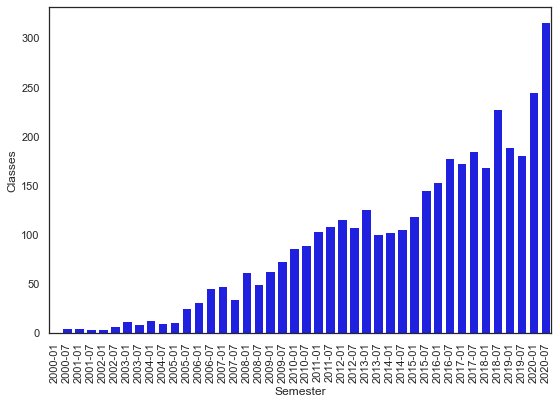

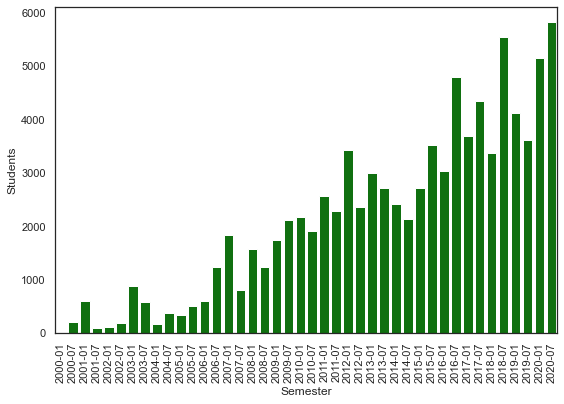

In [1159]:
## plot two bar plots
plt.figure(figsize=(9,6))

g = sns.barplot(months_sems2, cluster_ids_per_sem_nums, color='blue');
g.set_xticklabels(months_sems2, rotation=90)

plt.xlabel('Semester')
plt.ylabel('Classes')

# plt.savefig(cwd+'/appendixF_plots/class_by_semester_count.png', dpi=500,bbox_inches='tight')
plt.savefig(cwd+'/appendixF_plots/class_by_semester_count.eps',bbox_inches='tight')

plt.figure(figsize=(9,6))
g = sns.barplot(months_sems2, students_count, color='green');
g.set_xticklabels(months_sems2, rotation=90)

plt.xlabel('Semester')
plt.ylabel('Students')

# plt.savefig(cwd+'/appendixF_plots/student_by_semester_count.png', dpi=500, bbox_inches='tight')
plt.savefig(cwd+'/appendixF_plots/student_by_semester_count.eps', bbox_inches='tight')
# new name blue - classclust_semester_"algoname"_participants
# new name green _classes

In [983]:
## determine cumulative uniques
#students
cumulative_sem_students = []
unique_students = []
cumulative_classes = []

for i,j in enumerate(students):
    if i == 0:
        unique_students.append(len(set(j)))
        cumulative_sem_students.append(students_count[i])
        cumulative_classes.append(cluster_ids_per_sem_nums[i])
    elif i == len(students)-1:
        unique_students.append(len(set(np.concatenate(students[:i+1]))))
        cumulative_sem_students.append(students_count[i] + cumulative_sem_students[-1])
        cumulative_classes.append(cluster_ids_per_sem_nums[i] + cumulative_classes[-1])
    else:
        unique_students.append(len(set(np.concatenate(students[:i+1]))))
        cumulative_sem_students.append(students_count[i]+cumulative_sem_students[-1])  
        cumulative_classes.append(cluster_ids_per_sem_nums[i] + cumulative_classes[-1])

In [1015]:
starting_year = 2001

semester_list = ['Spring','Fall','Summer']
# group Spring and Summer togethre

months_sems3 = [datetime.datetime(2000, 7, 1, 0, 0)]

while starting_year < 2022:
    for i in semester_list:
        if i == 'Fall':
            months_sems3.append(datetime.datetime.strptime(str(starting_year)+'-07-01', '%Y-%m-%d') )
        elif i == 'Spring':
            months_sems3.append(datetime.datetime.strptime(str(starting_year)+'-01-01', '%Y-%m-%d') )
    starting_year += 1

In [1018]:
len(months_sems3[:-1])

42

In [1119]:
np.concatenate(students)

array(['0035w000034JFLHAA4', '0035w000034JGQQAA4', '0035w000034JEwlAAG',
       ..., '0035w00003D9yIVAAZ', '0035w00003DBEgKAAX',
       '0035w00003BRTpPAAX'], dtype=object)

In [1120]:
duplicate_students = list(np.concatenate(students))

In [1121]:
from itertools import groupby
intermed_student = [len(list(group)) for key, group in groupby(duplicate_students)]
np.where(np.array(intermed_student) > 1)

(array([ 9853, 76519, 82047, 87751, 88935], dtype=int64),)

In [1123]:
counter = 1
for key,group in groupby(duplicate_students):
    counter += 1
print(counter)

89726


In [1080]:
print(cumulative_sem_students[-1],unique_students[-1],cumulative_classes[-1])
print(cluster_ids_per_sem_nums[-1],len(set(np.concatenate(students[-1:]))))

89730 60357 3840
316 3776


In [1125]:
## percent diff
(89730-60357)/89730

0.32734871280508193

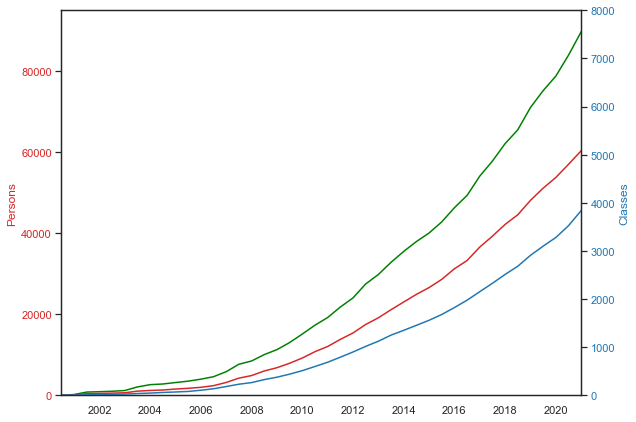

In [1160]:
# plot cumulative class and student count
fig, ax1 = plt.subplots(figsize=(9,6))

color = 'tab:red'
ax1.set_ylabel('Persons', color=color)
#ax1.plot(class_students_count.cumsum(), color=color)
ax1.plot(months_sems3[:-1], \
         cumulative_sem_students, color='Green')
ax1.plot(months_sems3[:-1], unique_students, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Classes', color=color)  # we already handled the x-label with ax1
ax2.plot(months_sems3[:-1],cumulative_classes, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.xlim([datetime.datetime(2000,7,1), datetime.datetime(2021,1,1)])

ax1.set_ylim([0, 95000])
ax1.grid(False)
ax2.set_ylim([0, 8000])
ax2.grid(False)

# plt.savefig(cwd+'/appendixF_plots/student_class_count.png', dpi=500, bbox_inches='tight')
plt.savefig(cwd+'/appendixF_plots/student_class_count.eps', bbox_inches='tight')

# add legend
plt.show()

# new name - same name as above + _cumulative_combined
# red - unique class participants
# blue - unique classes
# green - total class participants

## User Lifetime Comparison

In [1161]:
#pull jos_users with the previously found self-study, classroom, and research users
#then just compare the register vs last visit date

In [1162]:
sql_query = "select registerDate, lastvisitDate from jos_users where username in " + str(tuple(clustered_NH_username2['username']))
engine = sql.create_engine('mysql+pymysql://%s:%s@127.0.0.1/nanohub' \
                                               %('wang2506_ro', 'fnVnwcCS7iT45EsA'))

In [1163]:
clustered_dates = pd.read_sql_query(sql_query,engine)
clustered_dates

,registerDate,lastvisitDate
0,2000-01-11 17:10:00,NaT
1,2000-08-24 18:17:51,NaT
2,2000-08-29 19:43:43,NaT
3,2000-09-19 15:06:58,NaT
4,2001-01-11 00:20:23,NaT
...,...,...
61312,2021-01-21 22:45:04,2021-01-21 22:45:05
61313,2021-01-22 00:26:53,2021-01-22 00:26:54
61314,2021-01-22 19:02:00,2021-02-05 22:11:18
61315,2021-01-22 23:27:13,2021-01-22 23:27:14


In [1226]:
clustered_dates[clustered_dates['lastvisitDate'].isna()].shape[0]

1430

In [1227]:
## determine time diffs
clustered_dates2 = clustered_dates[~clustered_dates['lastvisitDate'].isna()].reset_index()
clustered_dates2['registerDate'] = pd.to_datetime(clustered_dates2['registerDate'])
clustered_dates2['lastvisitDate'] = pd.to_datetime(clustered_dates2['lastvisitDate'])
clustered_dates2['duration'] = clustered_dates2['lastvisitDate'].to_numpy() - clustered_dates2['registerDate'].to_numpy()
display(clustered_dates2.head(2))

,index,registerDate,lastvisitDate,duration
0,19,2005-07-28 01:28:13,2015-02-18 17:03:45,3492 days 15:35:32
1,26,2006-04-24 15:38:15,2007-11-12 00:56:00,566 days 09:17:45


In [1228]:
clustered_dates2['duration'] = [np.round(np.log10(i.days),2) for i in clustered_dates2['duration'].to_list()]
display(clustered_dates2.head(2))
display(clustered_dates2.tail(2))

C:\Users\ch5b2\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


,index,registerDate,lastvisitDate,duration
0,19,2005-07-28 01:28:13,2015-02-18 17:03:45,3.54
1,26,2006-04-24 15:38:15,2007-11-12 00:56:00,2.75


,index,registerDate,lastvisitDate,duration
59885,61315,2021-01-22 23:27:13,2021-01-22 23:27:14,-inf
59886,61316,2021-01-23 00:24:39,2021-01-23 00:24:40,-inf


In [1258]:
# 50 bins - log days
max_log_interval = 4 #base 10
bins = 50
# 1 day, 2 day, 3 day, 4, 5, 6, 1 week, 2 week, 1 month, 2 month, 1 year, 
bin_vals = [np.round(4/50*(i+1),2) for i in range(bins)] #these are the ending bin vals
bin_vals2 = [np.round(4/50*(i+1),2) for i in range(bins)] #these are the ending bin vals

In [1259]:
clustered_user_vals = []
for i,j in enumerate(bin_vals):
    if i == 0:
#         clustered_user_vals.append(clustered_dates[clustered_dates['lastvisitDate'].isna()].shape[0]\
#                                   +len(np.where(clustered_dates2['duration'] == 1)[0]))
        h_thresh = j
        l_thresh = 0
        clustered_user_vals.append(len(np.where((clustered_dates2['duration'] < h_thresh))[0]))
    else:
        h_thresh = j
        l_thresh = bin_vals[i-1]
        clustered_user_vals.append(len(np.where((clustered_dates2['duration'] > l_thresh) \
                                    & (clustered_dates2['duration'] < h_thresh))[0]))        

        

In [1268]:
clustered_user_vals[0]

14708

In [1281]:
clustered_user_vals2 = []
for i in clustered_user_vals:
    if i != 0:
        clustered_user_vals2.append(np.log10(i))
    else:
        clustered_user_vals2.append(0)

Text(0, 0.5, '# of Users (log)')

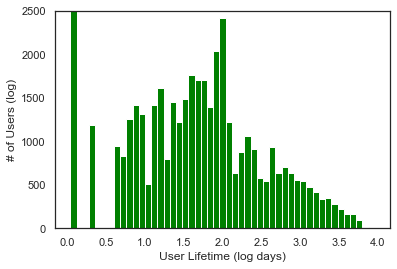

In [1285]:
plt.figure()
plt.hist(bin_vals2,bins=bin_vals2,weights=clustered_user_vals,align='left',color='green')
plt.xlabel('User Lifetime (log days)')
plt.xticks(np.arange(0,4.5,0.5))
plt.ylim([0,2500])
plt.ylabel('# of Users (log)')


plt.savefig('classroom_users_hist.eps',bbox_inches='tight')

# new name - simuser_lifetime_class

In [1271]:
sql_query = "select registerDate, lastvisitDate from jos_users where username in " + str(tuple(self_NH_username2['username']))
engine = sql.create_engine('mysql+pymysql://%s:%s@127.0.0.1/nanohub' \
                                               %('wang2506_ro', 'fnVnwcCS7iT45EsA'))

In [1272]:
self_study_dates = pd.read_sql_query(sql_query,engine)
self_study_dates

,registerDate,lastvisitDate
0,2014-11-13 21:09:09,NaT
1,2008-11-19 22:51:04,2008-11-19 23:55:30
2,2008-11-18 17:29:56,2020-02-14 18:50:14
3,2008-11-11 19:17:04,NaT
4,2014-06-26 19:38:57,NaT
...,...,...
174709,2021-02-02 05:30:45,2021-02-02 05:30:45
174710,2021-02-02 05:33:19,2021-02-02 05:33:20
174711,2021-02-02 05:42:48,2021-02-02 05:42:49
174712,2021-02-02 06:26:49,2021-02-02 06:26:49


In [1273]:
## determine time diffs
self_study_dates2 = self_study_dates[~self_study_dates['lastvisitDate'].isna()].reset_index()
self_study_dates2['registerDate'] = pd.to_datetime(self_study_dates2['registerDate'])
self_study_dates2['lastvisitDate'] = pd.to_datetime(self_study_dates2['lastvisitDate'])
self_study_dates2['duration'] = self_study_dates2['lastvisitDate'].to_numpy() - self_study_dates2['registerDate'].to_numpy()
display(self_study_dates2.head(2))

,index,registerDate,lastvisitDate,duration
0,1,2008-11-19 22:51:04,2008-11-19 23:55:30,0 days 01:04:26
1,2,2008-11-18 17:29:56,2020-02-14 18:50:14,4105 days 01:20:18


In [1275]:
self_study_dates2['duration'] = [np.round(np.log10(i.days),2) for i in self_study_dates2['duration'].to_list()]
display(self_study_dates2.head(2))
display(self_study_dates2.tail(2))

C:\Users\ch5b2\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
C:\Users\ch5b2\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


,index,registerDate,lastvisitDate,duration
0,1,2008-11-19 22:51:04,2008-11-19 23:55:30,-inf
1,2,2008-11-18 17:29:56,2020-02-14 18:50:14,3.61


,index,registerDate,lastvisitDate,duration
162289,174712,2021-02-02 06:26:49,2021-02-02 06:26:49,-inf
162290,174713,2021-02-02 06:28:45,2021-02-02 06:28:45,-inf


In [1276]:
self_user_vals = []
for i,j in enumerate(bin_vals):
    if i == 0:
#         clustered_user_vals.append(clustered_dates[clustered_dates['lastvisitDate'].isna()].shape[0]\
#                                   +len(np.where(clustered_dates2['duration'] == 1)[0]))
        h_thresh = j
        l_thresh = 0
        self_user_vals.append(len(np.where((self_study_dates2['duration'] < h_thresh))[0]))
    else:
        h_thresh = j
        l_thresh = bin_vals[i-1]
        self_user_vals.append(len(np.where((self_study_dates2['duration'] > l_thresh) \
                                    & (self_study_dates2['duration'] < h_thresh))[0]))        

        

In [1278]:
self_user_vals[:5]

[99609, 0, 0, 2241, 0]

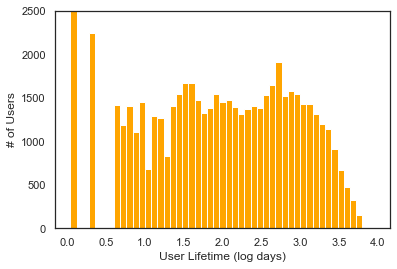

In [1293]:
plt.figure()
plt.hist(bin_vals2,bins=bin_vals2,weights=self_user_vals,align='left',color='orange')
plt.xlabel('User Lifetime (log days)')
plt.xticks(np.arange(0,4.5,0.5))
plt.ylim([0,2500])
plt.ylabel('# of Users')


plt.savefig('self_users_hist.eps',bbox_inches='tight')

# new name - drop class for _unclass

In [1287]:
sql_query = "select registerDate, lastvisitDate from jos_users where username in " + str(tuple(researcher_usernames))
engine = sql.create_engine('mysql+pymysql://%s:%s@127.0.0.1/nanohub' \
                                               %('wang2506_ro', 'fnVnwcCS7iT45EsA'))

In [1288]:
researcher_dates = pd.read_sql_query(sql_query,engine)
researcher_dates

,registerDate,lastvisitDate
0,2018-10-15 20:17:27,2018-10-15 20:17:28
1,2018-11-28 05:10:25,2018-11-28 05:10:26
2,2019-05-01 18:10:10,2019-05-02 07:11:32
3,2019-07-22 09:05:54,2019-07-22 09:05:55
4,2019-10-24 07:33:20,2019-10-24 07:33:20
...,...,...
2670,2012-11-10 13:15:17,2018-09-17 19:09:23
2671,2008-06-23 20:31:47,2017-04-07 20:00:13
2672,2019-10-22 04:14:44,2019-10-22 04:14:45
2673,2020-02-03 20:14:28,2020-05-07 00:24:57


In [1289]:
## determine time diffs
researcher_dates2 = researcher_dates[~researcher_dates['lastvisitDate'].isna()].reset_index()
researcher_dates2['registerDate'] = pd.to_datetime(researcher_dates2['registerDate'])
researcher_dates2['lastvisitDate'] = pd.to_datetime(researcher_dates2['lastvisitDate'])
researcher_dates2['duration'] = researcher_dates2['lastvisitDate'].to_numpy() - researcher_dates2['registerDate'].to_numpy()
display(researcher_dates2.head(2))

,index,registerDate,lastvisitDate,duration
0,0,2018-10-15 20:17:27,2018-10-15 20:17:28,00:00:01
1,1,2018-11-28 05:10:25,2018-11-28 05:10:26,00:00:01


In [1290]:
researcher_dates2['duration'] = [np.round(np.log10(i.days),2) for i in researcher_dates2['duration'].to_list()]
display(researcher_dates2.head(2))
display(researcher_dates2.tail(2))

C:\Users\ch5b2\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


,index,registerDate,lastvisitDate,duration
0,0,2018-10-15 20:17:27,2018-10-15 20:17:28,-inf
1,1,2018-11-28 05:10:25,2018-11-28 05:10:26,-inf


,index,registerDate,lastvisitDate,duration
2550,2673,2020-02-03 20:14:28,2020-05-07 00:24:57,1.97
2551,2674,2005-09-07 13:19:25,2010-03-19 23:00:05,3.22


In [1291]:
researcher_vals = []
for i,j in enumerate(bin_vals):
    if i == 0:
#         clustered_user_vals.append(clustered_dates[clustered_dates['lastvisitDate'].isna()].shape[0]\
#                                   +len(np.where(clustered_dates2['duration'] == 1)[0]))
        h_thresh = j
        l_thresh = 0
        researcher_vals.append(len(np.where((researcher_dates2['duration'] < h_thresh))[0]))
    else:
        h_thresh = j
        l_thresh = bin_vals[i-1]
        researcher_vals.append(len(np.where((researcher_dates2['duration'] > l_thresh) \
                                    & (researcher_dates2['duration'] < h_thresh))[0]))        

        

In [1302]:
researcher_vals[:2]

[653, 0]

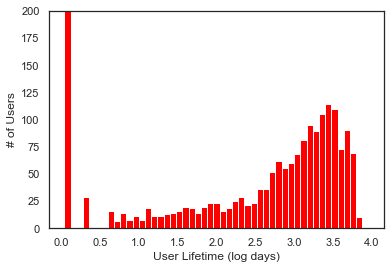

In [1300]:
plt.figure()
plt.hist(bin_vals2,bins=bin_vals2,weights=researcher_vals,align='left',color='red')
plt.xlabel('User Lifetime (log days)')
plt.xticks(np.arange(0,4.5,0.5))
plt.ylim([0,200])
plt.ylabel('# of Users')


plt.savefig('research_users_hist.eps',bbox_inches='tight')

# new name - _research
import os
cwd = os.getcwd()
prodpath - cwd+'/plots_html/plotname'
debugpath - cwd+'/plots_debug/plotname' #add a .gitignore here
# should dump out the data as well
cwd + /plots_html/plotname.csv

In [1305]:
clustered_NH_username2['username'].to_csv("clustered_users.csv")

In [1306]:
self_NH_username2['username'].to_csv('self_study_users.csv')

In [1310]:
tt_temp = pd.DataFrame()
tt_temp['usernames'] = researcher_usernames
tt_temp.to_csv('researchers.csv')